In [ ]:
# Cell 1: 라이브러리 설치
!pip install -q transformers[torch] datasets evaluate rouge_score bert_score pandas tqdm spacy sentencepiece
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 160.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Cell 2: 데이터 및 모델 준비
import torch
import pandas as pd
import numpy as np
import spacy
import gc
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import evaluate
from sentence_transformers import SentenceTransformer



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# --- 모델 설정 (Base 버전 3개) ---
MODEL_CONFIGS = {
    'bert': "bert-base-uncased",
    'electra': "google/electra-base-discriminator",
    'xlnet': "xlnet-base-cased"
}

loaded_models = {}
print("모델 로딩 중...")

for name, model_id in MODEL_CONFIGS.items():
    print(f" -> {name} 로드 중...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # XLNet 호환성을 위해 output_attentions=True 명시
    model = AutoModel.from_pretrained(model_id, output_attentions=True).to(device)
    model.eval()
    loaded_models[name] = {'tokenizer': tokenizer, 'model': model}

# SpaCy 로드
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000
print("준비 완료!")

Device: cuda
모델 로딩 중...
 -> bert 로드 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

 -> electra 로드 중...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

 -> xlnet 로드 중...


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

준비 완료!


In [ ]:
# Cell 3: 핵심 문장 및 단어 추출 함수 (수정 버전)

def extract_key_sentence(text):
    # 뉴스 기사 길이 정도면 굳이 20000자로 안 잘라도 되지만, 안전을 위해 유지
    safe_text = text[:10000]
    doc = nlp(safe_text)
    sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.split()) > 10]

    if not sentences:
        return text[:300]

    # 가장 긴 문장 선택
    return max(sentences, key=lambda s: len(s.split()))


def get_keywords_from_model(model_name, text, target_n):
    """
    text      : 전체 문서 (original 기사 전체)
    target_n  : 뽑고 싶은 '키워드 수'
    - 더 이상 주제문 길이, 문서 길이로 early-return 하지 않음
    - 무조건 text 전체를 보고 상위 중요도 토큰에서 n개 선택
    """
    pkg = loaded_models[model_name]
    tokenizer = pkg['tokenizer']
    model = pkg['model']

    # 전체 문서를 그대로 넣되, 모델 최대 길이(512 토큰)까지만 사용
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

    with torch.no_grad():
        outputs = model(**inputs)

    # 중요도 계산
    if hasattr(outputs, 'attentions'):
        # 마지막 레이어 attention 사용
        attentions = outputs.attentions[-1]           # (batch, heads, seq, seq)
        att_map = attentions.mean(dim=1).squeeze(0)   # (seq, seq)
        token_importance = att_map.sum(dim=0)         # (seq,)
    else:
        # XLNet 등 attention이 없을 때는 hidden state norm 사용
        hidden = outputs.last_hidden_state.squeeze(0) # (seq, dim)
        token_importance = torch.norm(hidden, dim=1)  # (seq,)

    # 점수 매핑 및 추출
    candidates = []
    special_tokens = tokenizer.all_special_tokens

    for idx, (token, score) in enumerate(zip(tokens, token_importance)):
        if token in special_tokens:
            continue

        clean_word = token.replace(u'\u2581', "").replace("##", "").strip()
        if not clean_word:
            continue
        if not clean_word[0].isalnum():
            continue

        candidates.append({
            "index": idx,
            "word": clean_word,
            "score": score.item()
        })

    # 중요도(score) 기준 정렬 후 상위 n개 선택
    candidates.sort(key=lambda x: x['score'], reverse=True)

    top_k = candidates[:target_n]  # 문서가 짧으면 자동으로 min(len, n)개
    # 원래 토큰 순서대로 정렬
    top_k.sort(key=lambda x: x['index'])

    return " ".join([item['word'] for item in top_k])


In [ ]:
# Cell 4: "오버샘플링" 방식의 고속 데이터 로드 및 실험

import gc
import re

# --- 설정값 ---
SAMPLES_PER_DATASET = 2000   # 최종 목표 개수 (각 데이터셋당)
BUFFER_SIZE = 2500           # 넉넉하게 가져올 개수 (불량 대비 1.25배)
TARGET_LENGTHS = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# 평가 지표 로드
print("평가 지표 로딩 중...")
metric_bert = evaluate.load("bertscore")
metric_rouge = evaluate.load("rouge")


# ===== Density 계산용 보조 함수 =====
def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    # 알파벳/숫자 기준으로 토큰 추출, 전부 소문자
    return re.findall(r"\w+", text.lower())


def compute_density(pred, original):
    """
    pred     : 모델이 뽑은 키워드 문자열
    original : 원문 기사 전체 (row["doc"])
    density  : pred 단어들 중 original에도 등장하는 단어 비율
    """
    pred_tokens = simple_tokenize(pred)
    orig_tokens = simple_tokenize(original)

    if not pred_tokens:
        return 0.0

    pred_set = set(pred_tokens)
    orig_set = set(orig_tokens)

    overlap = pred_set & orig_set
    density = len(overlap) / len(pred_tokens)

    return density
# ===================================


def load_news_data_fast(target_count, buffer_size):
    data = []

    # 여기서부터: 실제로 로드할 데이터셋 정의
    sources = [
        # 1) cnn_dailymail: 기존과 동일
        {
            "name": "cnn_dailymail",
            "config": "3.0.0",
            "text_field": "article",
            "summary_field": "highlights",
            "extra_kwargs": {}
        },
        # 2) xsum: Parquet 브랜치 사용 (스크립트 없이 동작)
        {
            "name": "EdinburghNLP/xsum",
            "config": None,
            "text_field": "document",
            "summary_field": "summary",
            "extra_kwargs": {"revision": "refs/convert/parquet"}
        },
        # 3) multi_news: 커뮤니티 parquet 버전
        {
            "name": "Awesome075/multi_news_parquet",
            "config": None,
            "text_field": "document",
            "summary_field": "summary",
            "extra_kwargs": {}
        },
    ]

    print(f"\n--- 데이터 로드 시작 (목표: {target_count}개 / 버퍼: {buffer_size}개) ---")

    for src in sources:
        name = src["name"]
        conf = src["config"]
        text_col = src["text_field"]
        summ_col = src["summary_field"]
        extra_kwargs = src["extra_kwargs"]

        print(f" -> Fetching {name}...", end=" ")
        try:
            # 1. 데이터셋 연결 (streaming=True, trust_remote_code는 쓰지 않음)
            if conf:
                ds = load_dataset(
                    name,
                    conf,
                    split="test",
                    streaming=True,
                    **extra_kwargs
                )
            else:
                ds = load_dataset(
                    name,
                    split="test",
                    streaming=True,
                    **extra_kwargs
                )

            # 2. 버퍼만큼 한 번에 가져오기
            raw_data = list(ds.take(buffer_size))

            # 3. 불량 데이터 고속 필터링
            valid_items = []
            for item in raw_data:
                original = item[text_col]
                ref = item[summ_col]

                # 유효성 검사 (None 체크, 문자열 체크, 너무 짧은 글 제외)
                if (
                    original
                    and isinstance(original, str)
                    and len(original.strip()) > 50
                ):
                    valid_items.append(
                        {
                            "dataset": name,
                            "doc": original,
                            "ref": ref,
                        }
                    )

                # 목표 개수 채웠으면 중단
                if len(valid_items) >= target_count:
                    break

            # 4. 결과 저장
            data.extend(valid_items)
            print(f" 완료! ({len(valid_items)}개 확보)")

        except Exception as e:
            print(f"\n[Fatal Error] {name} 로드 중 문제 발생: {e}")

    return pd.DataFrame(data)


# 1. 데이터 로드 실행
df_data = load_news_data_fast(SAMPLES_PER_DATASET, BUFFER_SIZE)

print(f"\n총 로드된 데이터 수: {len(df_data)}개")
if not df_data.empty:
    print("=== 데이터셋별 분포 확인 ===")
    print(df_data["dataset"].value_counts())
    print("============================\n")
else:
    print("데이터가 없습니다. 멈춥니다.")


# 2. 실험 루프
if not df_data.empty:
    results = []
    print("실험 시작 (tqdm 진행바를 확인하세요)...")

    for idx, row in tqdm(df_data.iterrows(), total=len(df_data)):
        dataset = row["dataset"]
        original = row["doc"]
        reference = row["ref"]

        try:
            key_sent = extract_key_sentence(original)
        except Exception:
            continue

        for n in TARGET_LENGTHS:
            row_result = {
                "dataset": dataset,
                "target_n": n,
                "key_sent": key_sent[:30] + "...",
            }

            for m_name in ["bert", "electra", "xlnet"]:
                # 1. 단어 추출: 전체 기사(original)에서 n개 키워드
                #   (앞에서 수정한 get_keywords_from_model 시그니처: (model_name, text, target_n))
                pred = get_keywords_from_model(m_name, original, n)
                real_len = len(pred.split())

                # 2. BERTScore
                b_score = metric_bert.compute(
                    predictions=[pred],
                    references=[reference],
                    lang="en",
                )["f1"][0]

                # 3. ROUGE-1
                r_score = metric_rouge.compute(
                    predictions=[pred],
                    references=[reference],
                )["rouge1"]

                # 4. Efficiency (BERTScore / 단어 수)
                efficiency = b_score / max(1, real_len)

                # 5. Density (pred 단어 중 original에 등장하는 비율)
                density = compute_density(pred, original)

                # 저장
                row_result[f"{m_name}_words"]      = pred
                row_result[f"{m_name}_bertscore"]  = b_score
                row_result[f"{m_name}_rouge1"]     = r_score
                row_result[f"{m_name}_eff"]        = efficiency
                row_result[f"{m_name}_density"]    = density

            results.append(row_result)

        # 주기적 메모리 정리
        if idx % 50 == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # 결과 저장
    df_res = pd.DataFrame(results)
    csv_name = "news_only_experiment_v3.csv"
    df_res.to_csv(csv_name, index=False)
    print(f"\n모든 실험 완료! 결과가 {csv_name}에 저장되었습니다.")
else:
    print("실험을 수행할 데이터가 없습니다.")


데이터 로드 완료: 48000 행
>>> Generating Combined Report...


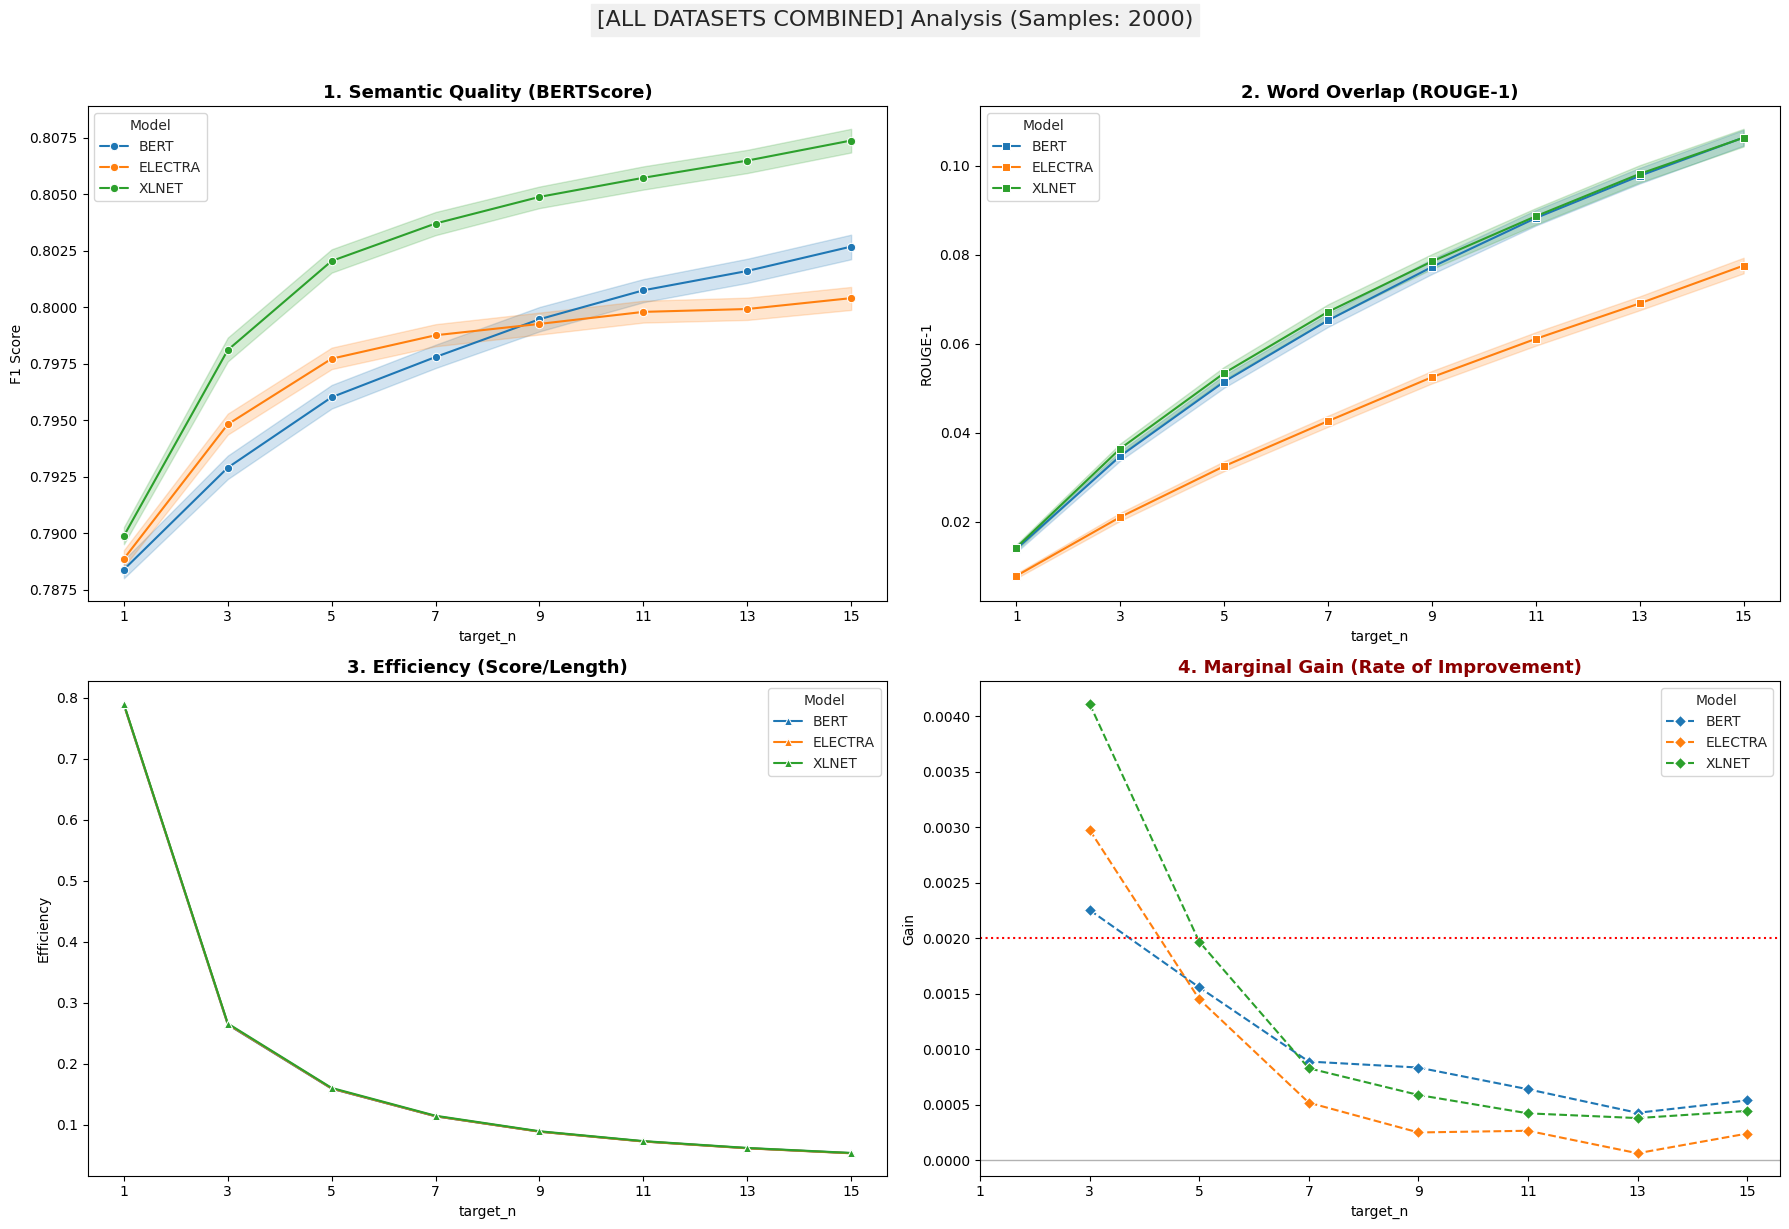



>>> Generating Report for cnn_dailymail...


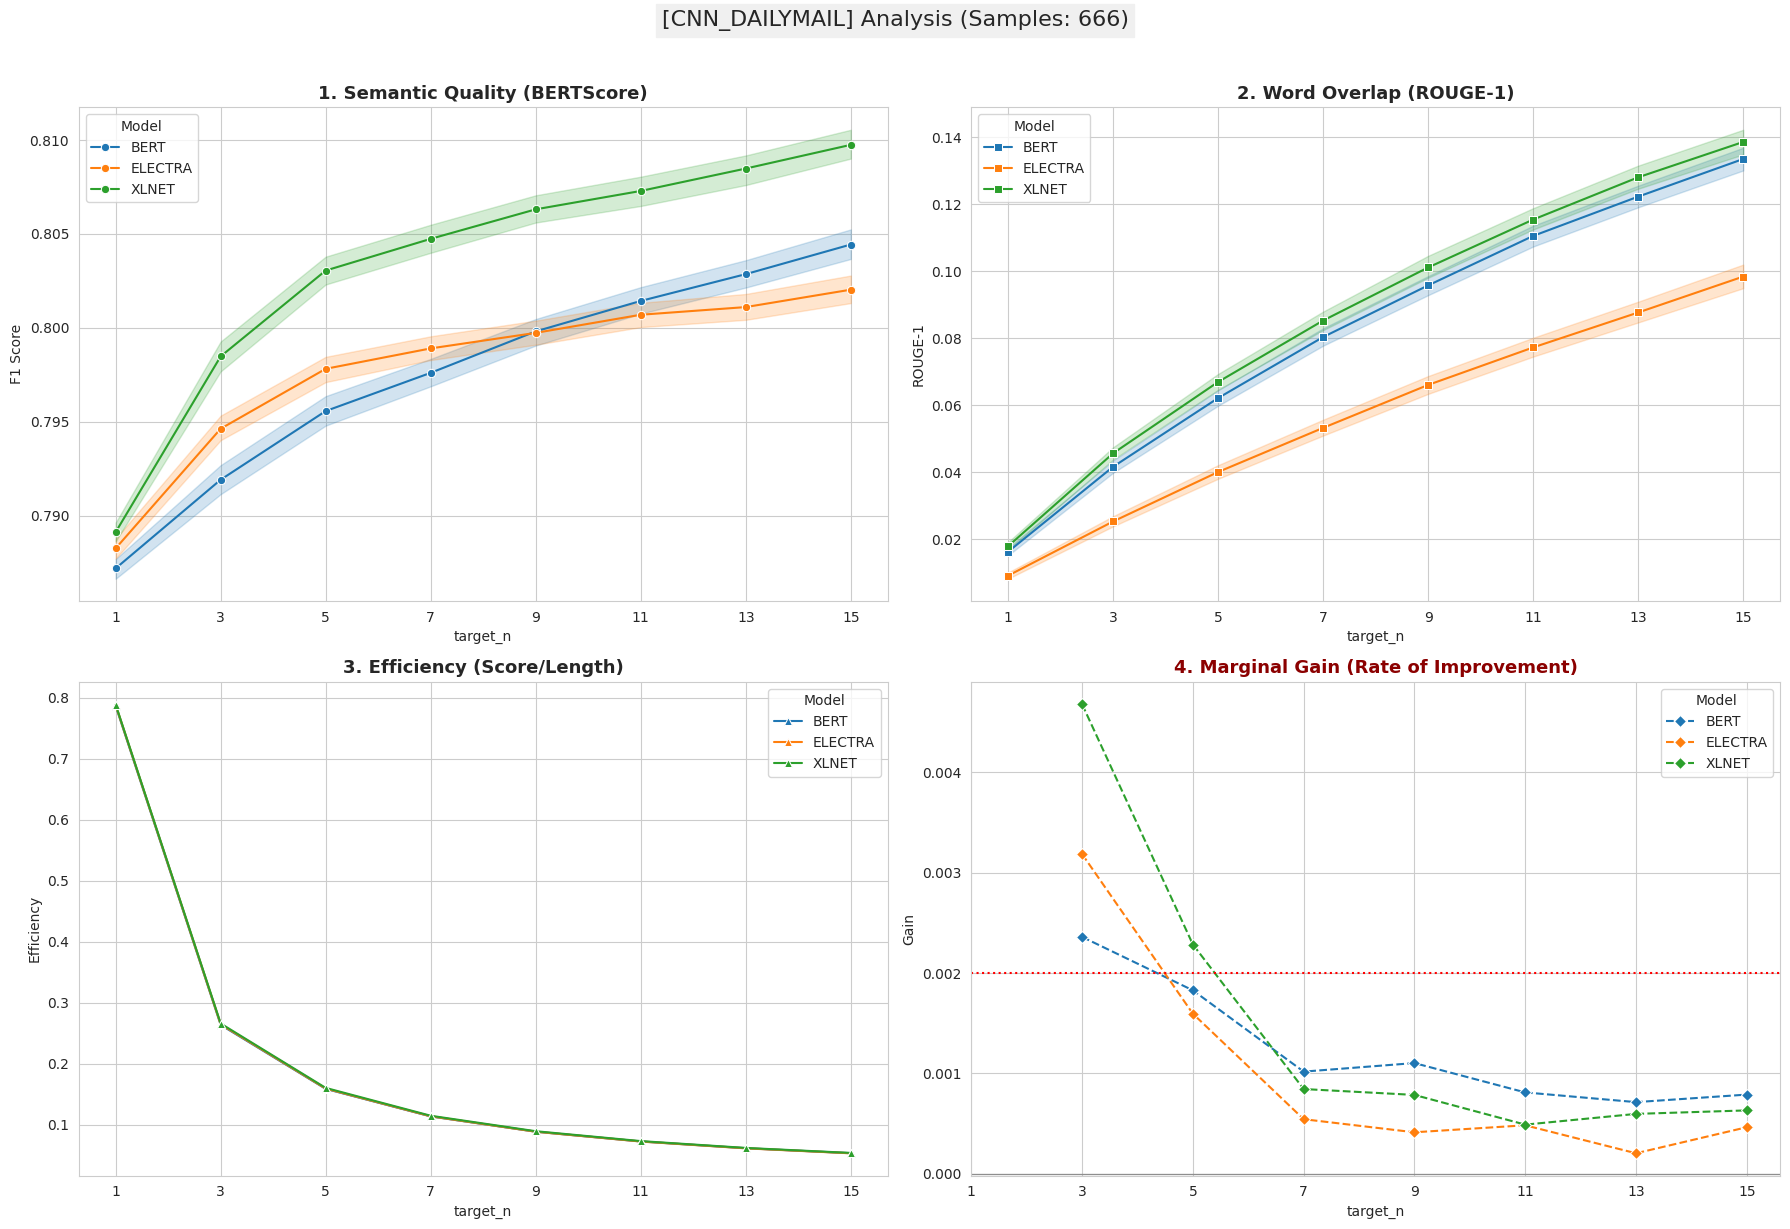



>>> Generating Report for EdinburghNLP/xsum...


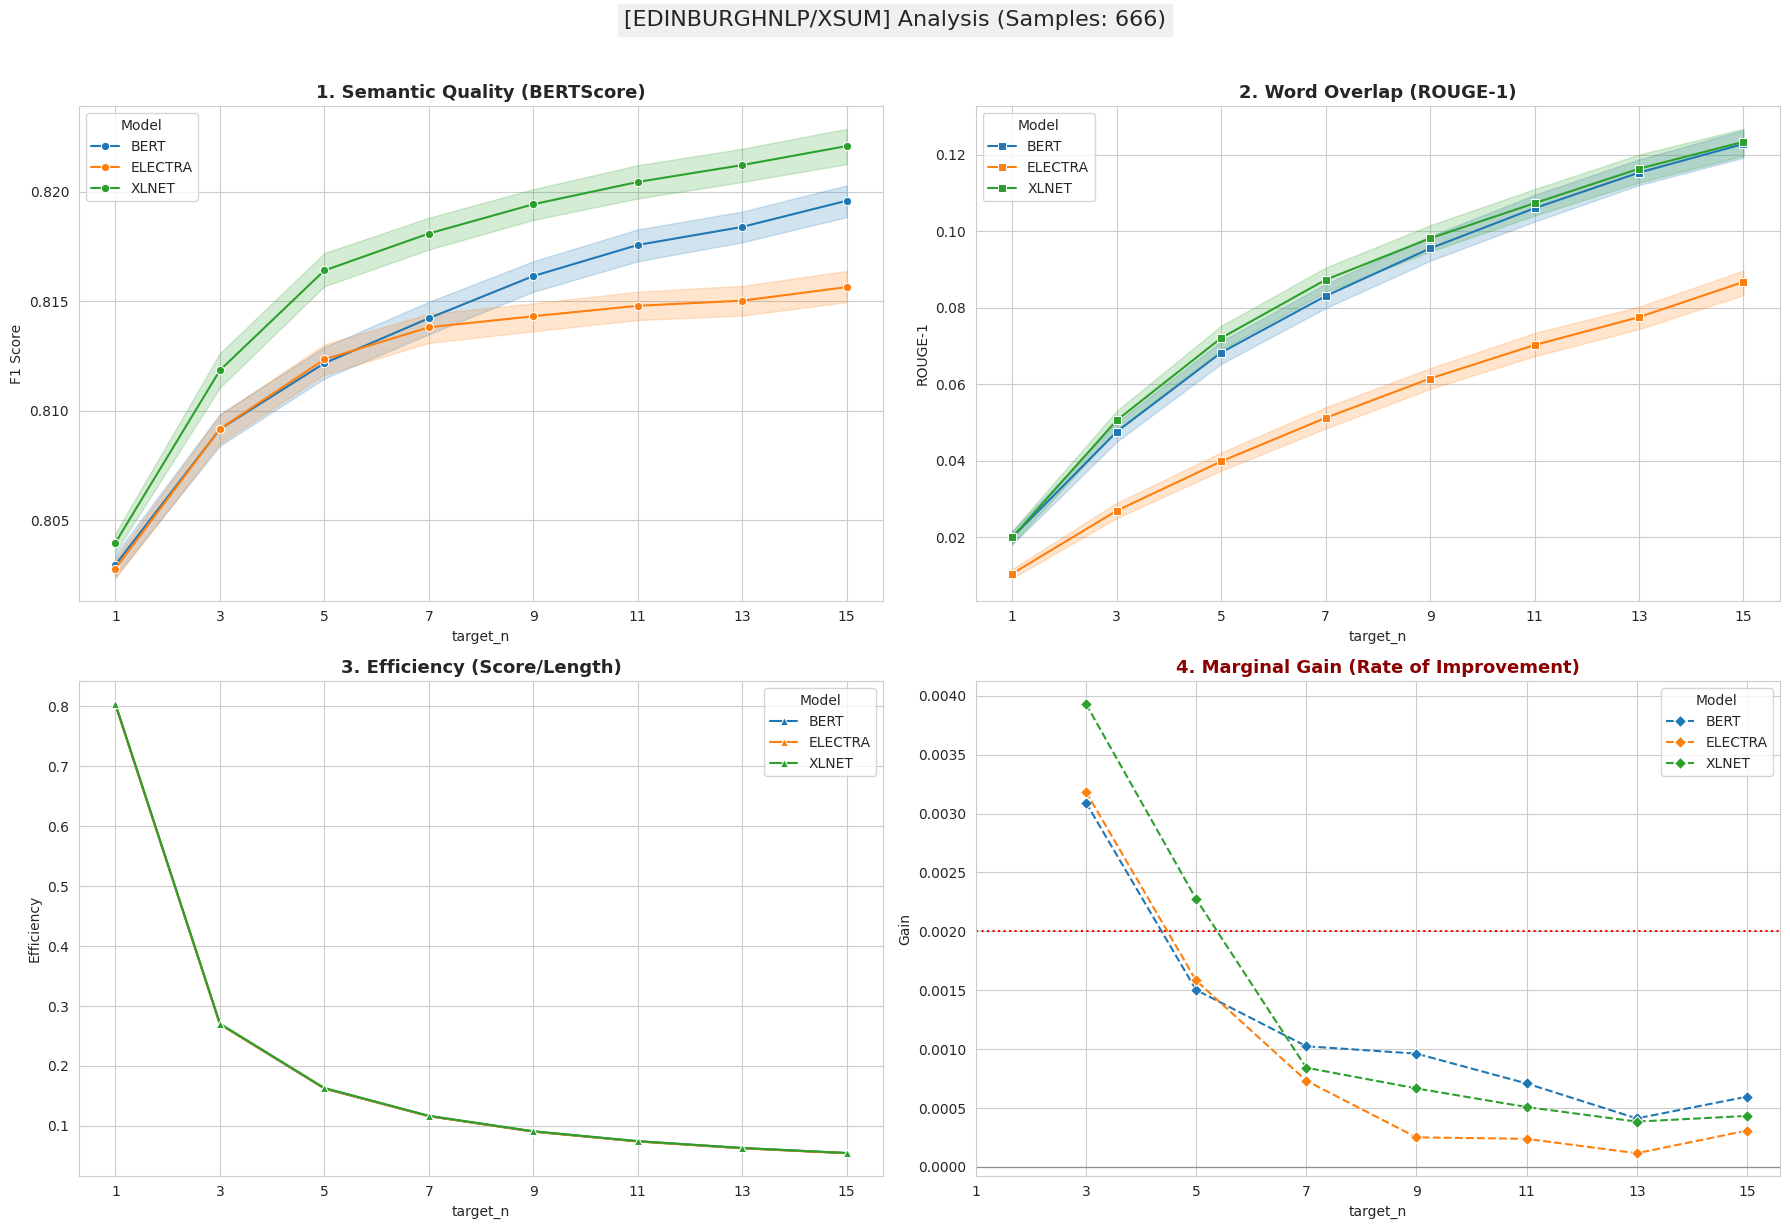



>>> Generating Report for Awesome075/multi_news_parquet...


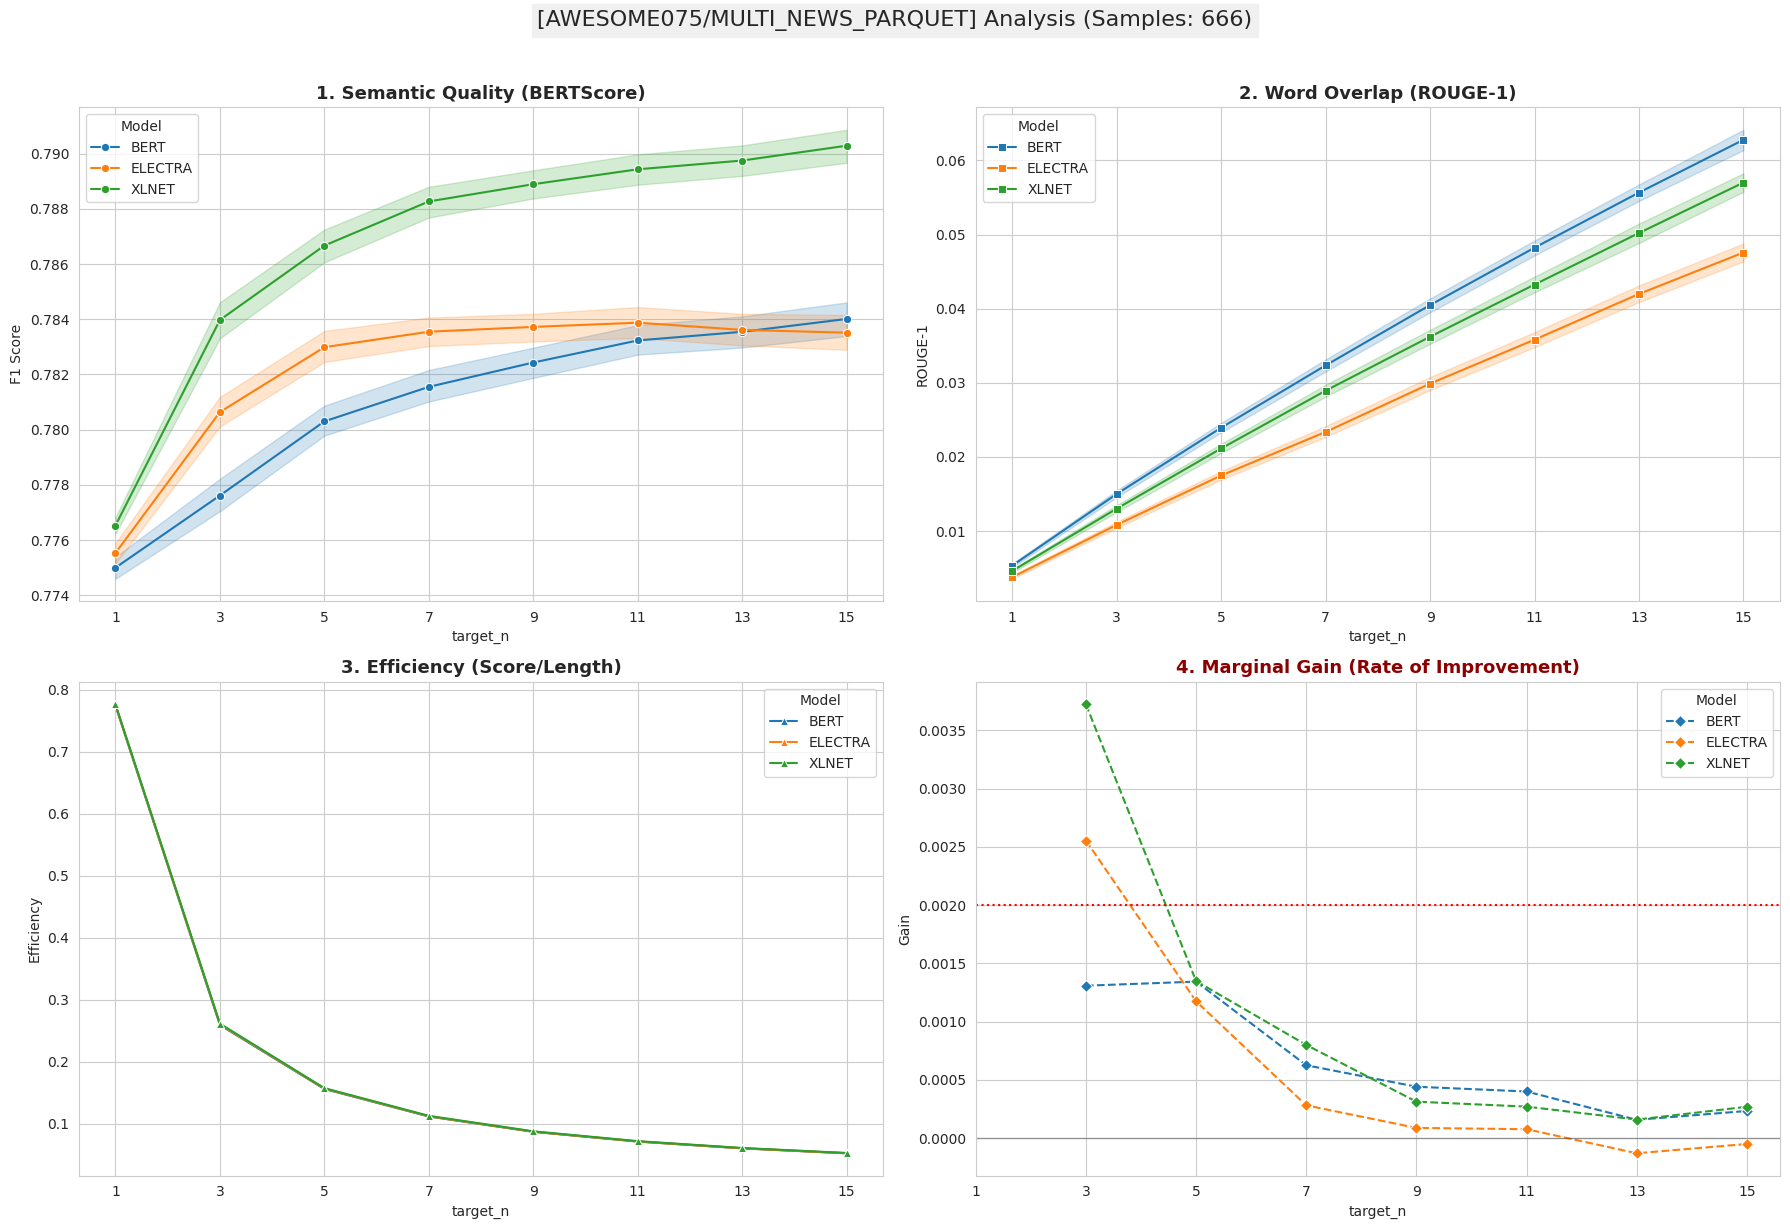

In [ ]:
# Cell 5: 최종 분석 및 시각화 (Elbow Point 표시 제거됨)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 데이터 로드
csv_name = "news_only_experiment_v3.csv"
try:
    df_res = pd.read_csv(csv_name)
    print(f"데이터 로드 완료: {len(df_res)} 행")
except:
    print("CSV 파일을 찾을 수 없습니다. Cell 4를 먼저 실행해주세요.")
    df_res = pd.DataFrame()

# --- 시각화 함수 정의 ---
def draw_analysis_plots(df_target, title_prefix):

    # 1. 한계 이득(Marginal Gain) 계산
    # 해당 데이터셋 내에서 단어 수 별 평균 구하기
    df_avg = df_target.groupby('target_n')[
        ['bert_bertscore', 'electra_bertscore', 'xlnet_bertscore']
    ].mean()

    # 차분(Diff) / 2 (단어 2개당 변화량이므로)
    df_marginal = df_avg.diff() / 2
    df_marginal = df_marginal.reset_index()

    # Melting (Long Format 변환)
    df_marginal_melt = df_marginal.melt(
        id_vars=['target_n'],
        value_vars=['bert_bertscore', 'electra_bertscore', 'xlnet_bertscore'],
        var_name='Model', value_name='Marginal_Gain'
    )
    df_marginal_melt['Model'] = df_marginal_melt['Model'].str.replace('_bertscore', '').str.upper()

    # 기존 지표 Melting
    # (A) Quality (BERTScore)
    df_bert = df_target.melt(id_vars=['target_n'], value_vars=['bert_bertscore', 'electra_bertscore', 'xlnet_bertscore'], var_name='Model', value_name='Score')
    df_bert['Model'] = df_bert['Model'].str.replace('_bertscore', '').str.upper()

    # (B) ROUGE
    df_rouge = df_target.melt(id_vars=['target_n'], value_vars=['bert_rouge1', 'electra_rouge1', 'xlnet_rouge1'], var_name='Model', value_name='Score')
    df_rouge['Model'] = df_rouge['Model'].str.replace('_rouge1', '').str.upper()

    # (C) Efficiency
    df_eff = df_target.melt(id_vars=['target_n'], value_vars=['bert_eff', 'electra_eff', 'xlnet_eff'], var_name='Model', value_name='Score')
    df_eff['Model'] = df_eff['Model'].str.replace('_eff', '').str.upper()

    # --- 그래프 그리기 (2x2) ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # 사이즈 넉넉하게
    sns.set_style("whitegrid")
    target_lengths = sorted(df_target['target_n'].unique())

    # [1] Quality
    sns.lineplot(data=df_bert, x='target_n', y='Score', hue='Model', marker='o', ax=axes[0, 0])
    axes[0, 0].set_title(f"1. Semantic Quality (BERTScore)", fontsize=13, fontweight='bold')
    axes[0, 0].set_xticks(target_lengths)
    axes[0, 0].set_ylabel("F1 Score")

    # [2] ROUGE
    sns.lineplot(data=df_rouge, x='target_n', y='Score', hue='Model', marker='s', ax=axes[0, 1])
    axes[0, 1].set_title(f"2. Word Overlap (ROUGE-1)", fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(target_lengths)
    axes[0, 1].set_ylabel("ROUGE-1")

    # [3] Efficiency (Elbow Point 표시 제거됨)
    sns.lineplot(data=df_eff, x='target_n', y='Score', hue='Model', marker='^', ax=axes[1, 0])
    axes[1, 0].set_title(f"3. Efficiency (Score/Length)", fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(target_lengths)
    axes[1, 0].set_ylabel("Efficiency")

    # [4] Marginal Gain
    sns.lineplot(data=df_marginal_melt, x='target_n', y='Marginal_Gain', hue='Model', marker='D', ax=axes[1, 1], linestyle='--')
    axes[1, 1].set_title(f"4. Marginal Gain (Rate of Improvement)", fontsize=13, fontweight='bold', color='darkred')
    axes[1, 1].set_xticks(target_lengths)
    axes[1, 1].set_ylabel("Gain")
    # 0점 기준선은 분석에 중요하므로 남겨둡니다.
    axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    axes[1, 1].axhline(0.002, color='red', linestyle=':', label='Threshold')

    # 전체 타이틀
    plt.suptitle(f"[{title_prefix}] Analysis (Samples: {len(df_target)//24})", fontsize=16, y=1.02, backgroundcolor='#f0f0f0')
    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")


# 2. 실행 로직
if not df_res.empty:
    # (1) 전체 통합 버전 출력
    print(">>> Generating Combined Report...")
    draw_analysis_plots(df_res, "ALL DATASETS COMBINED")

    # (2) 데이터셋별 개별 버전 출력
    datasets = df_res['dataset'].unique()
    for ds_name in datasets:
        print(f">>> Generating Report for {ds_name}...")
        df_subset = df_res[df_res['dataset'] == ds_name]
        draw_analysis_plots(df_subset, ds_name.upper())

else:
    print("데이터가 없습니다.")

>>> [전체 데이터] 정보 밀집도 분석


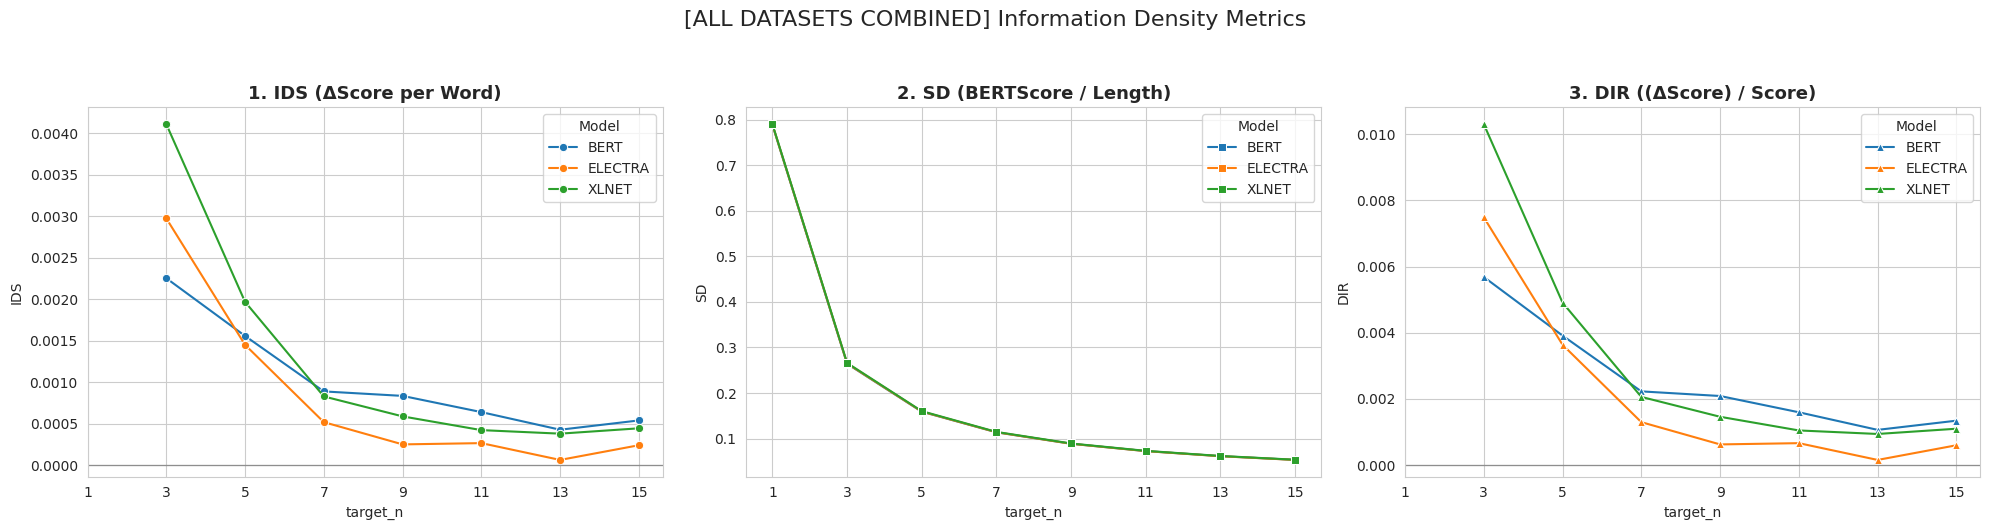


[ALL DATASETS COMBINED] 최적 target_n 요약

- IDS (정보 증가량 기준):
  BERT    → target_n = 3, value = 0.002254
  ELECTRA → target_n = 3, value = 0.002975
  XLNET   → target_n = 3, value = 0.004111

- SD  (정보 밀집도 기준):
  BERT    → target_n = 1, value = 0.788391
  ELECTRA → target_n = 1, value = 0.788865
  XLNET   → target_n = 1, value = 0.789881

- DIR (새 정보 비율 기준):
  BERT    → target_n = 3, value = 0.005685
  ELECTRA → target_n = 3, value = 0.007487
  XLNET   → target_n = 3, value = 0.010302


>>> [cnn_dailymail] 정보 밀집도 분석


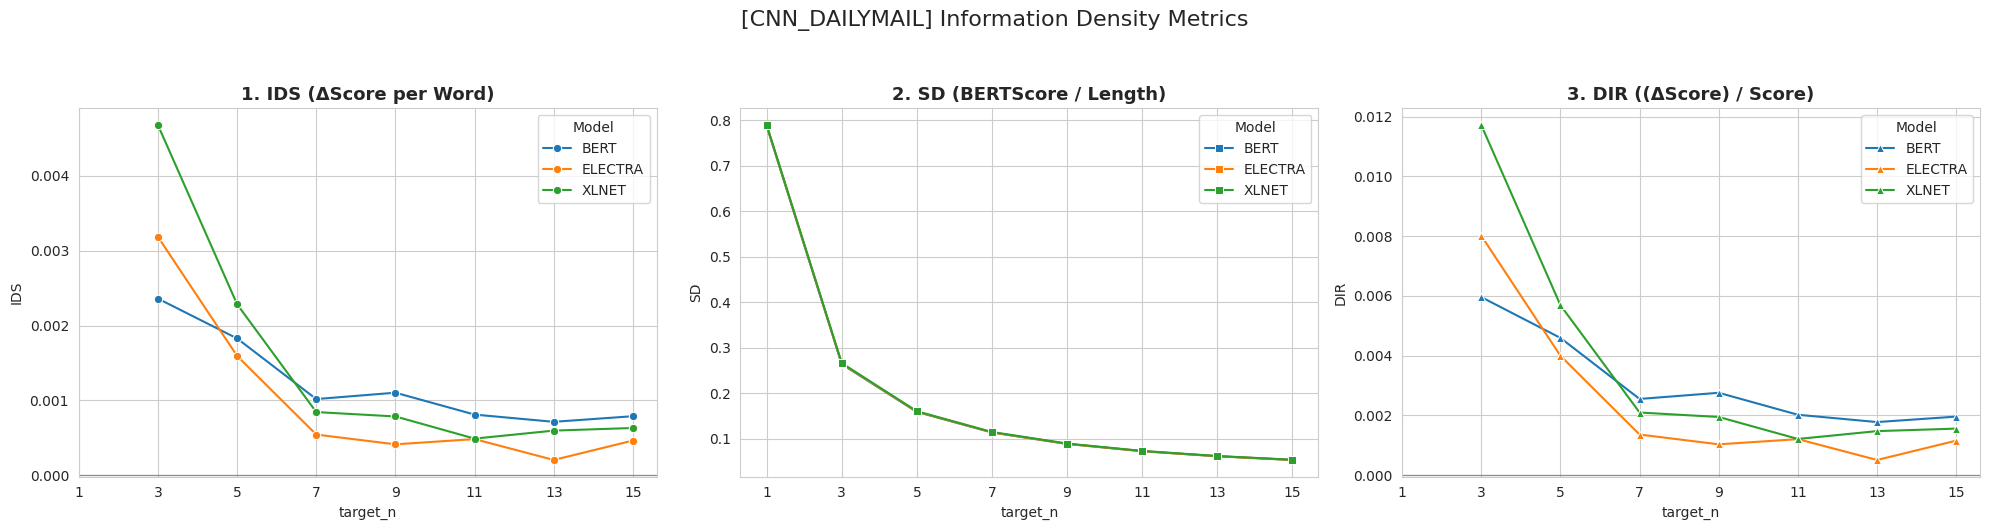


[CNN_DAILYMAIL] 최적 target_n 요약

- IDS (정보 증가량 기준):
  BERT    → target_n = 3, value = 0.002360
  ELECTRA → target_n = 3, value = 0.003185
  XLNET   → target_n = 3, value = 0.004678

- SD  (정보 밀집도 기준):
  BERT    → target_n = 1, value = 0.787199
  ELECTRA → target_n = 1, value = 0.788264
  XLNET   → target_n = 1, value = 0.789129

- DIR (새 정보 비율 기준):
  BERT    → target_n = 3, value = 0.005960
  ELECTRA → target_n = 3, value = 0.008016
  XLNET   → target_n = 3, value = 0.011717


>>> [EdinburghNLP/xsum] 정보 밀집도 분석


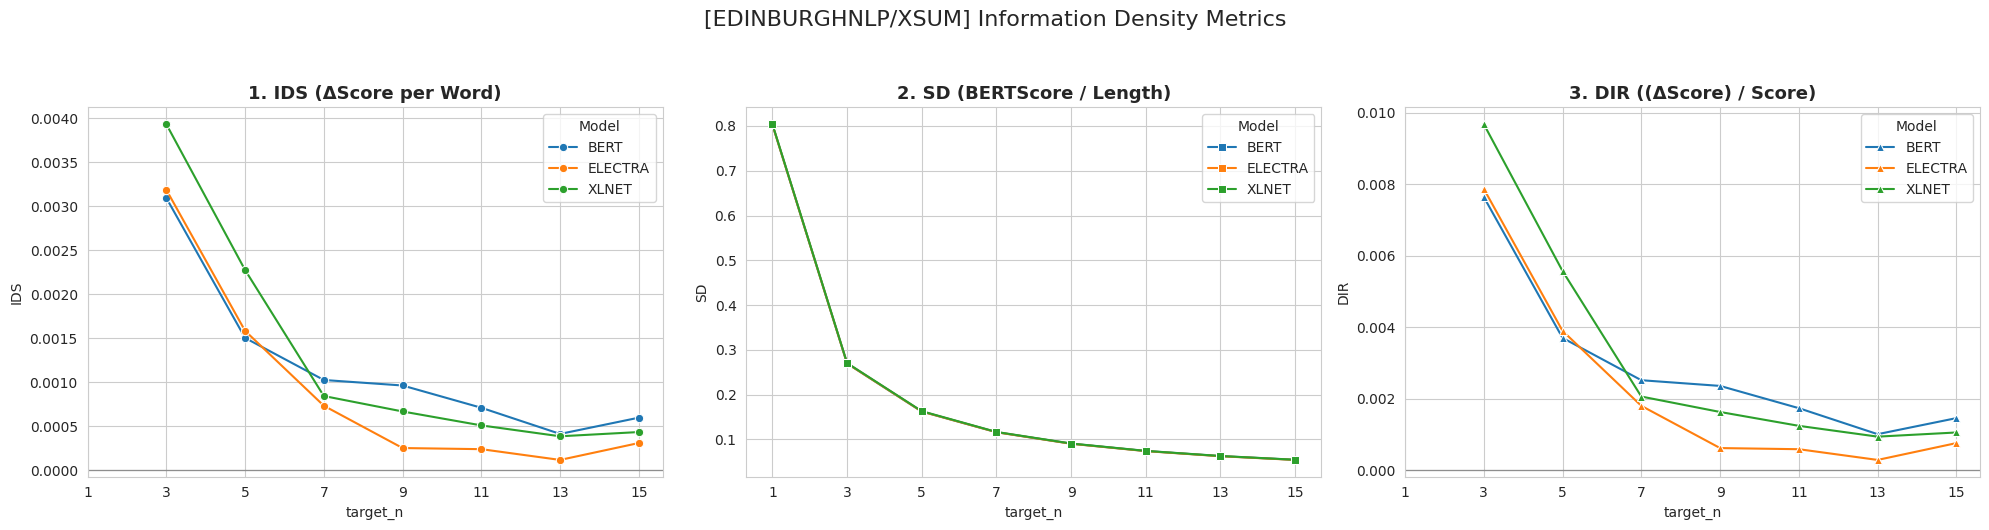


[EDINBURGHNLP/XSUM] 최적 target_n 요약

- IDS (정보 증가량 기준):
  BERT    → target_n = 3, value = 0.003094
  ELECTRA → target_n = 3, value = 0.003187
  XLNET   → target_n = 3, value = 0.003932

- SD  (정보 밀집도 기준):
  BERT    → target_n = 1, value = 0.802977
  ELECTRA → target_n = 1, value = 0.802804
  XLNET   → target_n = 1, value = 0.803987

- DIR (새 정보 비율 기준):
  BERT    → target_n = 3, value = 0.007647
  ELECTRA → target_n = 3, value = 0.007876
  XLNET   → target_n = 3, value = 0.009686


>>> [Awesome075/multi_news_parquet] 정보 밀집도 분석


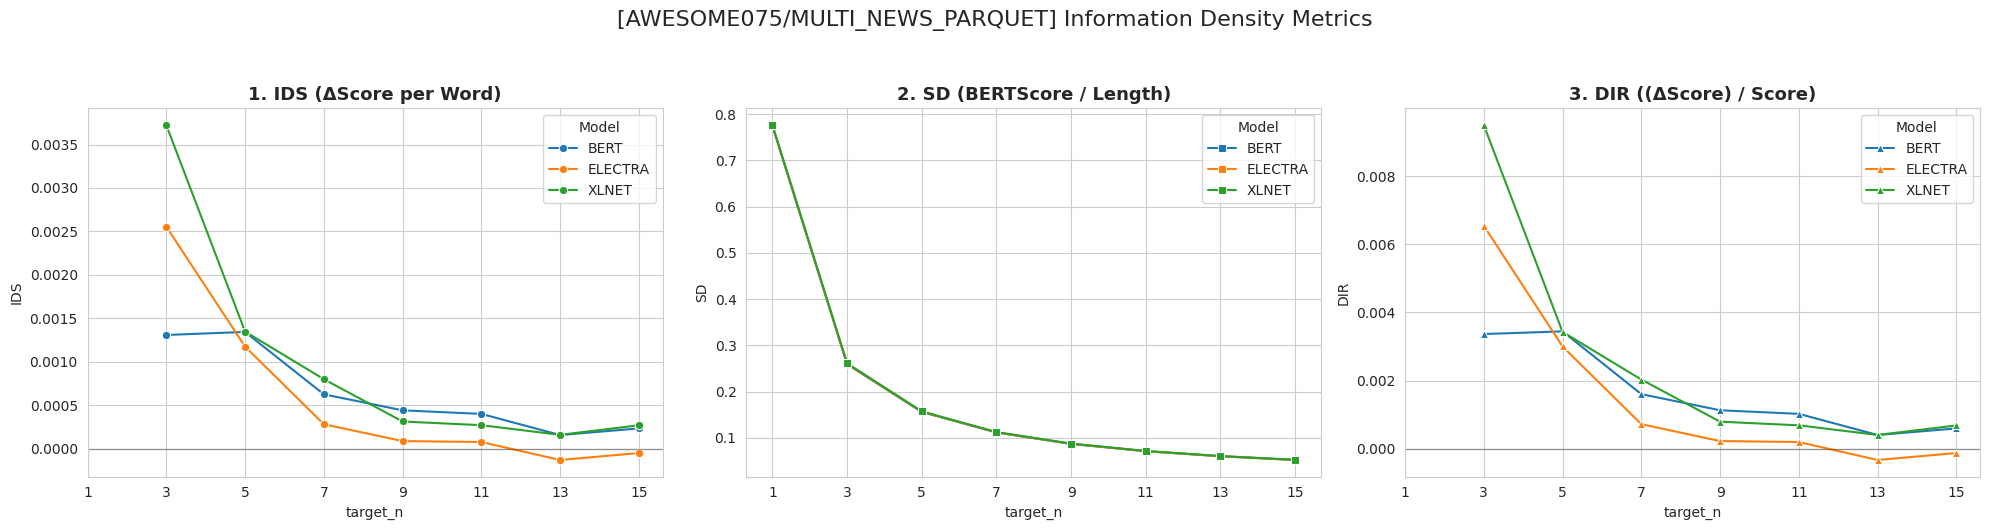


[AWESOME075/MULTI_NEWS_PARQUET] 최적 target_n 요약

- IDS (정보 증가량 기준):
  BERT    → target_n = 5, value = 0.001343
  ELECTRA → target_n = 3, value = 0.002554
  XLNET   → target_n = 3, value = 0.003724

- SD  (정보 밀집도 기준):
  BERT    → target_n = 1, value = 0.774996
  ELECTRA → target_n = 1, value = 0.775528
  XLNET   → target_n = 1, value = 0.776526

- DIR (새 정보 비율 기준):
  BERT    → target_n = 5, value = 0.003443
  ELECTRA → target_n = 3, value = 0.006545
  XLNET   → target_n = 3, value = 0.009500




In [ ]:
# Cell 6: 정보 밀집도 기반 메트릭 계산 및 시각화

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# df_res가 있는지 확인
if df_res.empty:
    raise ValueError("df_res가 비어 있습니다. Cell 4/5를 먼저 실행해 주세요.")

# 공통: 사용할 BERTScore 컬럼들
BERT_COLS = ['bert_bertscore', 'electra_bertscore', 'xlnet_bertscore']


def compute_density_tables(df_target):
    """
    df_target: 하나의 데이터셋(또는 전체)만 필터링된 df_res
    반환: df_avg, df_ids, df_sd, df_dir (모두 wide 형식)
    """
    # target_n 별 평균 BERTScore (기본)
    df_avg = df_target.groupby('target_n')[BERT_COLS].mean().reset_index()

    # ---- 1) IDS: Information Density Score = (Score(n) - Score(n-2)) / 2
    df_ids = df_avg.copy()
    for col in BERT_COLS:
        df_ids[col] = df_ids[col].diff() / 2.0  # 단어 1개당 증가량

    # ---- 2) SD: Semantic Density = Score(n) / n
    df_sd = df_avg.copy()
    for col in BERT_COLS:
        df_sd[col] = df_sd[col] / df_sd['target_n']

    # ---- 3) DIR: Differential Information Ratio
    #        = (Score(n) - Score(n-2)) / Score(n)
    df_dir = df_avg.copy()
    for col in BERT_COLS:
        diff = df_avg[col].diff()       # Score(n) - Score(n-2)
        df_dir[col] = diff / df_avg[col]

    return df_avg, df_ids, df_sd, df_dir


def melt_with_model_name(df_wide, value_name):
    """wide(df_wide) -> long(df_long) 형태로 변환 + Model 이름 정리"""
    df_long = df_wide.melt(
        id_vars=['target_n'],
        value_vars=BERT_COLS,
        var_name='Model',
        value_name=value_name,
    )
    df_long['Model'] = (
        df_long['Model']
        .str.replace('_bertscore', '', regex=False)
        .str.upper()
    )
    return df_long


def draw_density_plots_for(df_target, title_prefix="ALL"):
    """
    하나의 df_target(전체 또는 특정 dataset)에 대해
    IDS, SD, DIR 그래프와 함께 최적 target_n을 출력.
    """
    df_avg, df_ids, df_sd, df_dir = compute_density_tables(df_target)

    # Long-format 변환
    df_ids_long = melt_with_model_name(df_ids, 'IDS')
    df_sd_long  = melt_with_model_name(df_sd,  'SD')
    df_dir_long = melt_with_model_name(df_dir, 'DIR')

    target_lengths = sorted(df_avg['target_n'].unique())

    # ----- 시각화 (1 x 3)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{title_prefix}] Information Density Metrics", fontsize=16, y=1.05)

    # [1] IDS
    sns.lineplot(
        data=df_ids_long,
        x='target_n', y='IDS',
        hue='Model', marker='o', ax=axes[0]
    )
    axes[0].set_title("1. IDS (ΔScore per Word)", fontsize=13, fontweight='bold')
    axes[0].set_xticks(target_lengths)
    axes[0].set_xlabel("target_n")
    axes[0].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

    # [2] SD
    sns.lineplot(
        data=df_sd_long,
        x='target_n', y='SD',
        hue='Model', marker='s', ax=axes[1]
    )
    axes[1].set_title("2. SD (BERTScore / Length)", fontsize=13, fontweight='bold')
    axes[1].set_xticks(target_lengths)
    axes[1].set_xlabel("target_n")

    # [3] DIR
    sns.lineplot(
        data=df_dir_long,
        x='target_n', y='DIR',
        hue='Model', marker='^', ax=axes[2]
    )
    axes[2].set_title("3. DIR ((ΔScore) / Score)", fontsize=13, fontweight='bold')
    axes[2].set_xticks(target_lengths)
    axes[2].set_xlabel("target_n")
    axes[2].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ----- 각 메트릭별 최적 target_n 출력 (NaN 제외)
    print(f"\n[{title_prefix}] 최적 target_n 요약")

    def best_n_from_table(df_wide, metric_name):
        # df_wide: columns = ['target_n', bert_..., electra_..., xlnet_...]
        results = {}
        for col in BERT_COLS:
            series = df_wide[['target_n', col]].dropna()
            # 최대값을 주는 target_n
            idx = series[col].idxmax()
            best_n = int(series.loc[idx, 'target_n'])
            best_val = float(series.loc[idx, col])
            model_name = col.replace('_bertscore', '').upper()
            results[model_name] = (best_n, best_val)
        print(f"\n- {metric_name}:")
        for m, (n, v) in results.items():
            print(f"  {m:7s} → target_n = {n}, value = {v:.6f}")

    best_n_from_table(df_ids, "IDS (정보 증가량 기준)")
    best_n_from_table(df_sd,  "SD  (정보 밀집도 기준)")
    best_n_from_table(df_dir, "DIR (새 정보 비율 기준)")
    print("\n" + "="*80 + "\n")


# 1) 전체 데이터 기준 정보 밀집도 분석
print(">>> [전체 데이터] 정보 밀집도 분석")
draw_density_plots_for(df_res, "ALL DATASETS COMBINED")

# 2) 데이터셋별로도 분석하고 싶으면 아래 루프 사용
datasets = df_res['dataset'].unique()
for ds_name in datasets:
    print(f">>> [{ds_name}] 정보 밀집도 분석")
    df_subset = df_res[df_res['dataset'] == ds_name]
    draw_density_plots_for(df_subset, ds_name.upper())


In [ ]:
# Cell 1: 기본 세팅 + SBERT + 평가 지표

import gc
import re
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

import spacy
from datasets import load_dataset
from tqdm.auto import tqdm
import evaluate

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) 문장/토큰 임베딩용 SBERT
sbert = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# 2) spaCy 영어 모델
nlp = spacy.load("en_core_web_sm")

# 3) 평가 지표 로딩
print("평가 지표 로딩 중...")
metric_bert = evaluate.load("bertscore")
metric_rouge = evaluate.load("rouge")
print("준비 완료!")

# Cell 2: SBERT 기반 주제문 추출

def get_sentence_embedding(text: str):
    """
    한 문장을 SBERT 임베딩 벡터로 변환.
    """
    emb = sbert.encode(
        text,
        convert_to_tensor=True,
        normalize_embeddings=True  # L2 정규화
    )
    return emb  # (hidden,)


def extract_key_sentence(text: str) -> str:
    """
    문서 전체에서 '문서 임베딩과 코사인 유사도가 가장 높은 문장'을 주제문으로 선택.
    (Sentence-BERT 기반 대표 문장 선택)
    """

    if not isinstance(text, str) or not text.strip():
        return ""

    doc = nlp(text)

    # 문장 분리
    raw_sents = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 0]
    if not raw_sents:
        return text[:300].strip()

    # 너무 짧은 문장은 필터링 (예: 5단어 이하는 노이즈 취급)
    sentences = [s for s in raw_sents if len(s.split()) >= 5]
    if not sentences:
        sentences = raw_sents

    # 문장이 너무 많으면 전체에서 균등 샘플링
    MAX_SENTS = 80
    if len(sentences) > MAX_SENTS:
        idxs = np.linspace(0, len(sentences) - 1, MAX_SENTS).astype(int)
        sentences = [sentences[i] for i in idxs]

    # 1) 각 문장 SBERT 임베딩 구하기
    sent_embs = [get_sentence_embedding(s) for s in sentences]
    mat = torch.stack(sent_embs, dim=0)           # (num_sents, hidden)

    # 2) 문서 중심 벡터 = 문장 임베딩들의 평균
    doc_emb = mat.mean(dim=0, keepdim=True)       # (1, hidden)
    doc_emb = F.normalize(doc_emb, p=2, dim=1)

    # 3) 각 문장 vs 문서 중심 코사인 유사도 = dot product
    sims = torch.mv(mat, doc_emb[0])              # (num_sents,)

    # 4) 가장 유사도가 높은 문장 선택
    best_idx = int(torch.argmax(sims).item())
    return sentences[best_idx]

# Cell 3: Density 함수 + SBERT n단어 키워드 추출 + 뉴스 데이터 로더

# ----- Density 계산용 -----
def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    # 알파벳/숫자 기준으로 토큰 추출, 전부 소문자
    return re.findall(r"\w+", text.lower())


def compute_density(pred, original):
    """
    pred     : 모델이 뽑은 키워드 문자열
    original : 원문 기사 전체 (row["doc"])
    density  : pred 단어들 중 original에도 등장하는 단어 비율
    """
    pred_tokens = simple_tokenize(pred)
    orig_tokens = simple_tokenize(original)

    if not pred_tokens:
        return 0.0

    pred_set = set(pred_tokens)
    orig_set = set(orig_tokens)

    overlap = pred_set & orig_set
    density = len(overlap) / len(pred_tokens)

    return density
# --------------------------


# ----- SBERT 기반 키워드 추출 -----
def get_keywords_sbert(text, n_keywords):
    """
    Sentence-BERT token embeddings 기반으로 키워드 n개 추출.
    - token_embeddings vs sentence_embedding cosine similarity
    - 상위 n개 토큰을 원문 순서대로 정렬해서 반환
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    # token embeddings
    token_embs = sbert.encode(
        text,
        output_value="token_embeddings",
        convert_to_tensor=True
    )  # [seq_len, hidden]

    # sentence embedding
    sent_emb = sbert.encode(
        text,
        output_value="sentence_embedding",
        convert_to_tensor=True
    )  # [hidden]

    sims = cos_sim(token_embs, sent_emb).squeeze()     # [seq_len]

    # SentenceTransformer 내부 토크나이저 사용
    toks = sbert.tokenizer.tokenize(text)
    k = min(n_keywords, len(toks))
    if k == 0:
        return ""

    top_idx = torch.topk(sims, k=k).indices.cpu().tolist()
    # 순서 보존 위해 index 기준 정렬
    top_idx = sorted(top_idx)

    keywords = [toks[i] for i in top_idx]
    # ## 붙은 서브워드 정리 (아주 러프하게)
    cleaned = [w.replace("##", "") for w in keywords]

    return " ".join(cleaned)
# -------------------------------


# ----- 뉴스 데이터 로더 -----
SAMPLES_PER_DATASET = 130   # 각 데이터셋당 목표 샘플 수
BUFFER_SIZE = 200           # 스트리밍에서 take() 할 개수
TARGET_LENGTHS = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]


def load_news_data_fast(target_count, buffer_size):
    data = []

    # 실제로 로드할 데이터셋 정의
    sources = [
        {
            "name": "cnn_dailymail",
            "config": "3.0.0",
            "text_field": "article",
            "summary_field": "highlights",
            "extra_kwargs": {}
        },
        {
            "name": "EdinburghNLP/xsum",
            "config": None,
            "text_field": "document",
            "summary_field": "summary",
            "extra_kwargs": {"revision": "refs/convert/parquet"}
        },
        {
            "name": "Awesome075/multi_news_parquet",
            "config": None,
            "text_field": "document",
            "summary_field": "summary",
            "extra_kwargs": {}
        },
    ]

    print(f"\n--- 데이터 로드 시작 (목표: {target_count}개 / 버퍼: {buffer_size}개) ---")

    for src in sources:
        name = src["name"]
        conf = src["config"]
        text_col = src["text_field"]
        summ_col = src["summary_field"]
        extra_kwargs = src["extra_kwargs"]

        print(f" -> Fetching {name}...", end=" ")
        try:
            if conf:
                ds = load_dataset(
                    name,
                    conf,
                    split="test",
                    streaming=True,
                    **extra_kwargs
                )
            else:
                ds = load_dataset(
                    name,
                    split="test",
                    streaming=True,
                    **extra_kwargs
                )

            raw_data = list(ds.take(buffer_size))

            valid_items = []
            for item in raw_data:
                original = item[text_col]
                ref = item[summ_col]

                if (
                    original
                    and isinstance(original, str)
                    and len(original.strip()) > 50
                ):
                    valid_items.append(
                        {
                            "dataset": name,
                            "doc": original,
                            "ref": ref,
                        }
                    )

                if len(valid_items) >= target_count:
                    break

            data.extend(valid_items)
            print(f" 완료! ({len(valid_items)}개 확보)")

        except Exception as e:
            print(f"\n[Fatal Error] {name} 로드 중 문제 발생: {e}")

    return pd.DataFrame(data)


# 1. 데이터 로드 실행
df_data = load_news_data_fast(SAMPLES_PER_DATASET, BUFFER_SIZE)

print(f"\n총 로드된 데이터 수: {len(df_data)}개")
if not df_data.empty:
    print("=== 데이터셋별 분포 확인 ===")
    print(df_data["dataset"].value_counts())
    print("============================\n")
else:
    print("데이터가 없습니다. 멈춥니다.")

# Cell 4: SBERT baseline 실험 루프 + CSV 저장

if not df_data.empty:
    results = []
    print("실험 시작 (tqdm 진행바를 확인하세요)...")

    cnt_key_sent_fail = 0
    cnt_metric_fail = 0
    cnt_success = 0

    for idx, row in tqdm(df_data.iterrows(), total=len(df_data)):
        dataset = row["dataset"]
        original = row["doc"]
        reference = row["ref"]

        # 1) key sentence 추출
        try:
            key_sent = extract_key_sentence(original)
            if not isinstance(key_sent, str) or not key_sent.strip():
                cnt_key_sent_fail += 1
                continue
        except Exception as e:
            cnt_key_sent_fail += 1
            if cnt_key_sent_fail <= 5:
                print(f"[extract_key_sentence 실패] idx={idx}, error={e}")
            continue

        # 2) target_n별 실험
        for n in TARGET_LENGTHS:
            try:
                # (1) 키워드 추출
                pred = get_keywords_sbert(key_sent, n)
                real_len = len(pred.split())

                # 키워드가 아예 비었으면 스킵
                if real_len == 0:
                    continue

                # (2) BERTScore
                b_score = metric_bert.compute(
                    predictions=[pred],
                    references=[reference],
                    lang="en",
                )["f1"][0]

                # (3) ROUGE-1
                r_score = metric_rouge.compute(
                    predictions=[pred],
                    references=[reference],
                )["rouge1"]

                # (4) Efficiency
                eff = b_score / max(1, real_len)

                # (5) Density
                density = compute_density(pred, original)

                # (6) 결과 저장
                row_result = {
                    "dataset": dataset,
                    "target_n": n,
                    "key_sent": key_sent[:30] + "...",
                    "pred": pred,
                    "bertscore": b_score,
                    "rouge1": r_score,
                    "eff": eff,
                    "density": density,
                }
                results.append(row_result)
                cnt_success += 1

            except Exception as e:
                cnt_metric_fail += 1
                if cnt_metric_fail <= 5:
                    print(f"[metric 계산 실패] idx={idx}, n={n}, error={e}")
                continue

        # 주기적 메모리 정리
        if idx % 50 == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    print("\n=== 실험 종료 요약 ===")
    print(f"  key_sent 추출 실패 개수: {cnt_key_sent_fail}")
    print(f"  metric 계산 실패 개수 : {cnt_metric_fail}")
    print(f"  성공적으로 저장된 row 수: {cnt_success}")

    df_res = pd.DataFrame(results)
    csv_name = "news_only_sbert_baseline_v1.csv"
    df_res.to_csv(csv_name, index=False)
    print(f"\n모든 실험 완료! 결과가 {csv_name}에 저장되었습니다.")
    print(f"저장된 df_res shape: {df_res.shape}")
else:
    print("실험을 수행할 데이터가 없습니다.")




Device: cuda
평가 지표 로딩 중...
준비 완료!

--- 데이터 로드 시작 (목표: 130개 / 버퍼: 200개) ---
 -> Fetching cnn_dailymail...  완료! (130개 확보)
 -> Fetching EdinburghNLP/xsum... 

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 6a3e6446-10ea-4430-9896-079057871c9d)')' thrown while requesting GET https://huggingface.co/datasets/EdinburghNLP/xsum/resolve/b46d1408a83c7c650e4e3605e24dad5c9e06297a/default/train/0000.parquet
Retrying in 1s [Retry 1/5].


 완료! (130개 확보)
 -> Fetching Awesome075/multi_news_parquet...  완료! (130개 확보)

총 로드된 데이터 수: 390개
=== 데이터셋별 분포 확인 ===
dataset
cnn_dailymail                    130
EdinburghNLP/xsum                130
Awesome075/multi_news_parquet    130
Name: count, dtype: int64

실험 시작 (tqdm 진행바를 확인하세요)...


  0%|          | 0/390 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[metric 계산 실패] idx=0, n=11, error=list index out of range
[metric 계산 실패] idx=0, n=13, error=list index out of range
[metric 계산 실패] idx=0, n=15, error=list index out of range
[metric 계산 실패] idx=0, n=17, error=list index out of range
[metric 계산 실패] idx=0, n=19, error=list index out of range

=== 실험 종료 요약 ===
  key_sent 추출 실패 개수: 0
  metric 계산 실패 개수 : 2949
  성공적으로 저장된 row 수: 1341

모든 실험 완료! 결과가 news_only_sbert_baseline_v1.csv에 저장되었습니다.
저장된 df_res shape: (1341, 8)


In [ ]:
# Cell X: 숫자 지표만 추출하여 target_n별 평균 CSV 생성

import pandas as pd

# 1) df_res 존재 여부 확인 or CSV에서 불러오기
if 'df_res' not in globals():
    try:
        df_res = pd.read_csv("news_only_sbert_baseline_v1.csv")
        print("디스크에서 df_res를 읽어왔습니다:", df_res.shape)
    except FileNotFoundError:
        raise ValueError("df_res가 메모리에도 없고, news_only_sbert_baseline_v1.csv도 없습니다. "
                         "먼저 baseline 실험(Cell 4)을 실행하세요.")

if df_res.empty:
    raise ValueError("df_res가 비어 있습니다. baseline 실험 결과가 없습니다.")

print("원본 df_res shape:", df_res.shape)
print("원본 컬럼:", list(df_res.columns))

df_numeric = df_res.copy()

# 2) 단어 문자열 컬럼 제거 (예전 코드 호환용: *_words 컬럼이 있을 때만)
word_cols = [col for col in df_numeric.columns if col.endswith("_words")]
if word_cols:
    df_numeric = df_numeric.drop(columns=word_cols)
    print("제거된 word_cols:", word_cols)

# 3) key_sent도 제거
for col in ["key_sent", "pred", "dataset"]:
    if col in df_numeric.columns:
        df_numeric = df_numeric.drop(columns=[col])

print("숫자 평균에 사용할 컬럼:", list(df_numeric.columns))

# 4) 숫자 컬럼만 선택 (혹시 object 타입 섞여 있을 때 대비)
numeric_cols = df_numeric.select_dtypes(include=["number"]).columns.tolist()
if "target_n" not in numeric_cols and "target_n" in df_numeric.columns:
    # groupby 키로 쓸 거라 numeric_cols에서 빼도 됨
    numeric_cols.append("target_n")

df_numeric = df_numeric[numeric_cols]

# 5) target_n을 기준으로 숫자 지표 평균 계산
df_avg = df_numeric.groupby("target_n").mean().reset_index()

# 6) 새로운 CSV로 저장
avg_csv_name = "news_experiment_avg_by_n.csv"
df_avg.to_csv(avg_csv_name, index=False)

print(f"\ntarget_n별 평균 CSV 저장 완료: {avg_csv_name}")
print("생성된 컬럼 목록:", list(df_avg.columns))
print("\n미리보기:")
print(df_avg.head())


원본 df_res shape: (1341, 8)
원본 컬럼: ['dataset', 'target_n', 'key_sent', 'pred', 'bertscore', 'rouge1', 'eff', 'density']
숫자 평균에 사용할 컬럼: ['target_n', 'bertscore', 'rouge1', 'eff', 'density']

target_n별 평균 CSV 저장 완료: news_experiment_avg_by_n.csv
생성된 컬럼 목록: ['target_n', 'bertscore', 'rouge1', 'eff', 'density']

미리보기:
   target_n  bertscore    rouge1       eff   density
0         1   0.790627  0.009536  0.790627  0.905013
1         3   0.795136  0.029532  0.265045  0.944612
2         5   0.795063  0.042089  0.159013  0.926269
3         7   0.795329  0.052696  0.113618  0.920169
4         9   0.794704  0.064626  0.088300  0.914663


In [ ]:
# Cell 1: 기본 라이브러리 로드
import pandas as pd
# Cell 3: CSV 로드
df = pd.read_csv("Tuning2_RF_FIN.csv")

print(df.shape)
print(df.columns)
df.head()
# Cell 4: target_n = 9 인 행만 남기기
df_n9 = df[df["target_n"] == 9].copy()

print(df_n9.shape)
df_n9.head()
# Cell 5: article + model_type 기준으로 pivot
# article별로 baseline/rl 요약문을 나란히 두기
df_pivot = df_n9.pivot_table(
    index=["article"],      # 각 기사(원문) 기준
    columns="model_type",   # baseline / rl
    values="pred",          # 요약문 컬럼
    aggfunc="first"         # 중복 있을 경우 첫 값 사용
).reset_index()

# 열 이름 정리: baseline → pred_baseline, rl → pred_rl
df_pivot = df_pivot.rename(columns={
    "baseline": "pred_baseline",
    "rl": "pred_rl"
})

df_pivot.head()
# Cell 6: 필요한 열만 남기기
df_final = df_pivot[["article", "pred_baseline", "pred_rl"]]

print(df_final.shape)
df_final.head()
# Cell 7: 결과 CSV로 저장
output_path = "llm질문용.csv"
df_final.to_csv(output_path, index=False)

output_path


(1600, 14)
Index(['idx', 'target_n', 'article', 'reference', 'pred', 'pred_len',
       'ref_len', 'bert_f1', 'rouge1', 'rouge2', 'efficiency', 'density',
       'used_word_count', 'model_type'],
      dtype='object')
(400, 14)
(200, 3)


'llm질문용.csv'

/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


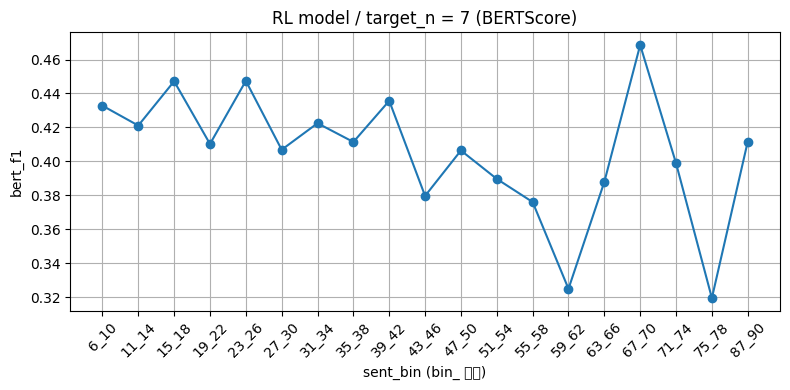

/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


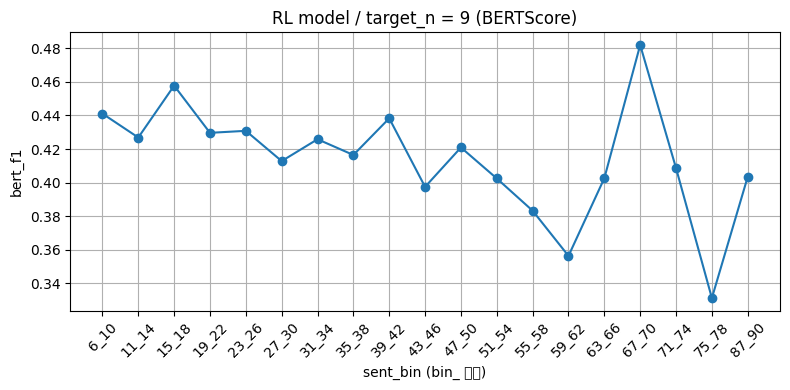

/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


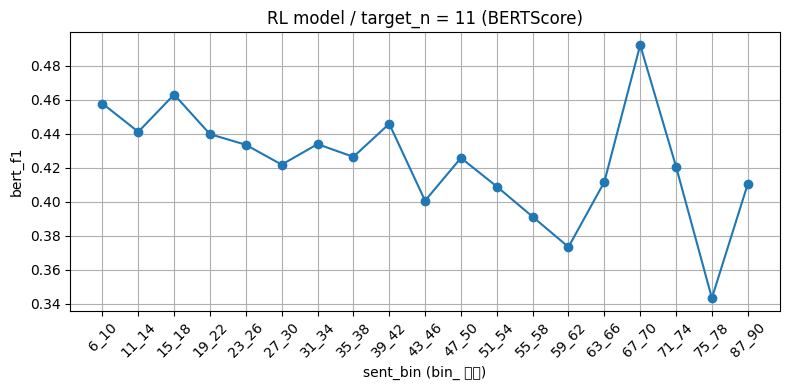

/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1024783372.py:46: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


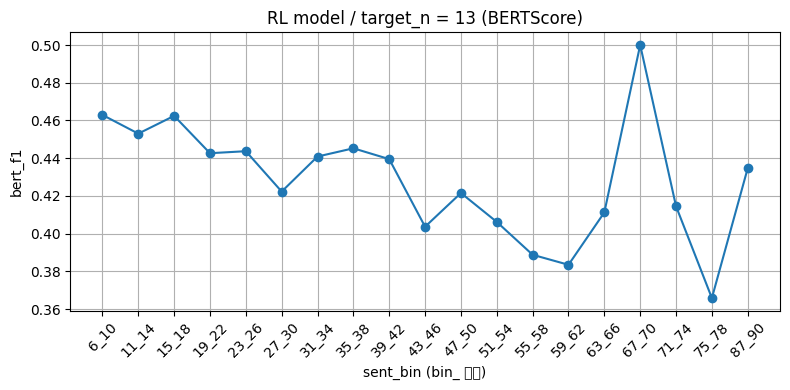

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) CSV 불러오기
file_path = "SENTBIN_MODEL_N_STATS.csv"   # 파일 경로
df = pd.read_csv(file_path)

# 2) rl 모델만 필터링
df = df[df["model_type"] == "rl"].copy()

# 3) bin_1_5 행 제거
df = df[df["sent_bin"] != "bin_1_5"]

# 4) sent_bin에서 "bin_" 접두어 제거
df["bin_label"] = df["sent_bin"].str.replace("bin_", "", regex=False)

# 5) 숫자 기준으로 정렬하기 위해 시작 구간 정수 추출
df["bin_start"] = df["bin_label"].str.split("_").str[0].astype(int)

# 대상 N값들
target_ns = [7, 9, 11, 13]

for n in target_ns:
    # 6) 특정 target_n만 선택
    df_n = df[df["target_n"] == n].copy()

    # bin별 bert_f1 평균값 계산
    grouped = (
        df_n.groupby(["bin_label", "bin_start"])["bert_f1"]
            .mean()
            .reset_index()
            .sort_values("bin_start")
    )

    x = grouped["bin_label"]      # x축: 예) 6_10, 11_14 ...
    y = grouped["bert_f1"]        # y축: bertscore 평균

    # 7) 그래프 그리기 (bert_f1만)
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, marker="o")
    plt.title(f"RL model / target_n = {n} (BERTScore)")
    plt.xlabel("sent_bin (bin_ 제거)")
    plt.ylabel("bert_f1")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
